In [8]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
#from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

Preprocessing and extracting keywords...
Clustering keywords into themes...
Assigning themes to reviews...
Saved to review_with_themes.csv


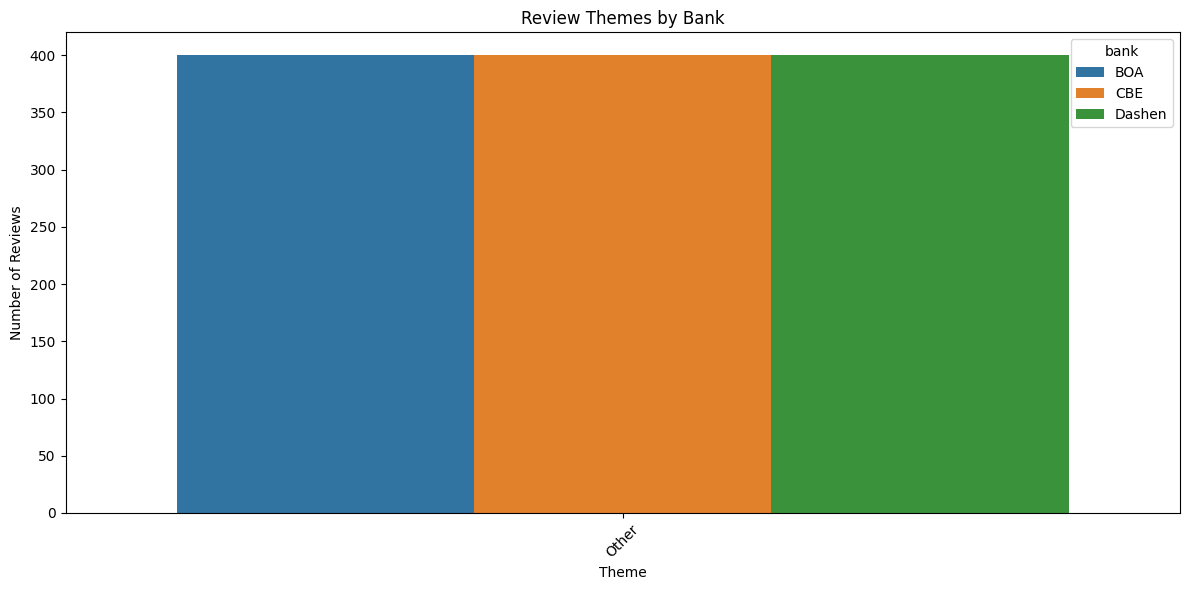

TypeError: cannot unpack non-iterable NoneType object

In [12]:


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove digits
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]
    return ' '.join(tokens)

def extract_keywords(df, max_features=100):
    """ Extract keywords using TF-IDF for each bank """
    df['clean_text'] = df['review'].apply(clean_text)
    
    keywords_per_bank = {}
    
    for bank in df['bank'].unique():
        bank_df = df[df['bank'] == bank]
        vectorizer = TfidfVectorizer(max_features=max_features)
        X = vectorizer.fit_transform(bank_df['clean_text'])
        keywords = vectorizer.get_feature_names_out()
        keywords_per_bank[bank] = keywords.tolist()
    
    return keywords_per_bank

def manually_cluster_keywords(keywords_per_bank):
    """ Group keywords into themes manually (example rule-based groups) """
    themes = {
        'Access Issues': ['login', 'authentication', 'fail', 'reset'],
        'Performance': ['slow', 'lag', 'freeze', 'crash', 'load'],
        'UI/UX': ['design', 'interface', 'navigation', 'menu'],
        'Features': ['transfer', 'statement', 'balance', 'notification'],
        'Support': ['help', 'service', 'support', 'response'],
    }

    keyword_to_theme = {}
    for theme, kw_list in themes.items():
        for kw in kw_list:
            keyword_to_theme[kw] = theme

    bank_theme_map = defaultdict(set)

    for bank, keywords in keywords_per_bank.items():
        for word in keywords:
            theme = keyword_to_theme.get(word)
            if theme:
                bank_theme_map[bank].add(theme)
    
    return {k: list(v) for k, v in bank_theme_map.items()}

def add_theme_column(df, themes):
    """ Adds a theme column to the DataFrame based on keyword matching """
    def detect_theme(text, bank):
        detected = set()
        for theme, kws in themes.items():
            for kw in kws:
                if kw in text:
                    detected.add(theme)
        return ', '.join(detected) if detected else 'Other'
    
    df['theme'] = df.apply(lambda row: detect_theme(row['clean_text'], row['bank']), axis=1)
    return df
def plot_themes_by_bank(df):
    """
    Plot a bar chart showing the number of reviews per theme, grouped by bank.
    """
    theme_counts = df.groupby(['bank', 'theme']).size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=theme_counts, x='theme', y='count', hue='bank')
    plt.title('Review Themes by Bank')
    plt.xlabel('Theme')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def thematic_analysis_pipeline(df):
    print("Preprocessing and extracting keywords...")
    keywords_per_bank = extract_keywords(df)
    print("Clustering keywords into themes...")
    clustered_themes = manually_cluster_keywords(keywords_per_bank)
    print("Assigning themes to reviews...")
    df = add_theme_column(df, clustered_themes)
    
    # Save CSV with themes
    df[['review', 'rating', 'date', 'bank', 'sentiment', 'theme']].to_csv("../data/review_with_themes.csv", index=False)
    print("Saved to review_with_themes.csv")
    return df, clustered_themes
def main_thematic():
    df = pd.read_csv('../data/reviews_with_sentiment.csv')  # from previous step
    df, themes = thematic_analysis_pipeline(df)
    df, themes = plot_themes_by_bank(df)
    print("\nTop Themes Per Bank:")
    for bank, theme_list in themes.items():
        print(f"{bank}: {', '.join(theme_list)}")

if __name__ == "__main__":
    main_thematic()